In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from conditional_VAE import conditional_VAE, loss_function

In [2]:
path = "/workspace/qing/mnist/cmnist/fgbg_cmnist_cpr0.5-0.5/"
mnist_train = torch.from_numpy(np.load(path + "colored_mnist_init_train.npy"))
mnist_test = torch.from_numpy(np.load(path + "colored_mnist_init_test.npy"))
mnist_train_target = torch.from_numpy(np.load(path + "colored_mnist_target_train.npy"))
mnist_test_target = torch.from_numpy(np.load(path + "colored_mnist_target_test.npy"))

batch_size = 128
train_dataset = TensorDataset(mnist_train, mnist_train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_dataset = TensorDataset(mnist_test, mnist_test_target)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(mnist_train.shape, mnist_test.shape)
print(mnist_train_target.shape, mnist_test_target.shape)

torch.Size([60000, 3, 28, 28]) torch.Size([10000, 3, 28, 28])
torch.Size([60000, 7]) torch.Size([10000, 7])


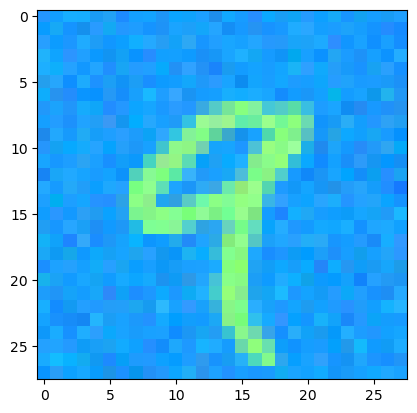

In [95]:
plt.imshow(mnist_train[4].permute(1, 2, 0))
plt.show()

In [5]:
torch.manual_seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Selected device: {device}")

vae = conditional_VAE(shape=(3, 28, 28), latent_dim=128, conditional_dim=7)
vae.to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

Selected device: cuda


In [6]:
def train_epoch(
    vae: conditional_VAE,
    device: torch.device,
    dataloader: DataLoader,
    optimizer: optim.Optimizer,
):
    train_loss = 0.0
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        x_hat, mean, logvar = vae(x, y)
        loss = loss_function(x, x_hat, mean, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)


def test_epoch(vae: conditional_VAE, device: torch.device, dataloader: DataLoader):
    val_loss = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            x_hat, mean, logvar = vae(x, y)
            loss = loss_function(x, x_hat, mean, logvar)

            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [80]:
num_epochs = 20

for epoch in range(num_epochs):
    train_loss = train_epoch(vae, device, train_loader, optimizer)
    val_loss = test_epoch(vae, device, test_loader)
    print(
        "\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}".format(
            epoch + 1, num_epochs, train_loss, val_loss
        )
    )


 EPOCH 1/20 	 train loss 21.470 	 val loss 81.612

 EPOCH 2/20 	 train loss 20.833 	 val loss 84.289

 EPOCH 3/20 	 train loss 20.241 	 val loss 82.875

 EPOCH 4/20 	 train loss 19.795 	 val loss 81.793

 EPOCH 5/20 	 train loss 19.402 	 val loss 82.620

 EPOCH 6/20 	 train loss 19.018 	 val loss 82.436

 EPOCH 7/20 	 train loss 18.682 	 val loss 81.024

 EPOCH 8/20 	 train loss 18.415 	 val loss 82.865

 EPOCH 9/20 	 train loss 18.178 	 val loss 81.378

 EPOCH 10/20 	 train loss 17.929 	 val loss 78.667

 EPOCH 11/20 	 train loss 17.623 	 val loss 78.959

 EPOCH 12/20 	 train loss 17.431 	 val loss 77.904

 EPOCH 13/20 	 train loss 17.279 	 val loss 79.081

 EPOCH 14/20 	 train loss 17.078 	 val loss 79.251

 EPOCH 15/20 	 train loss 16.926 	 val loss 76.145

 EPOCH 16/20 	 train loss 16.789 	 val loss 76.892

 EPOCH 17/20 	 train loss 16.666 	 val loss 76.444

 EPOCH 18/20 	 train loss 16.551 	 val loss 75.962

 EPOCH 19/20 	 train loss 16.436 	 val loss 76.817

 EPOCH 20/20 	 train

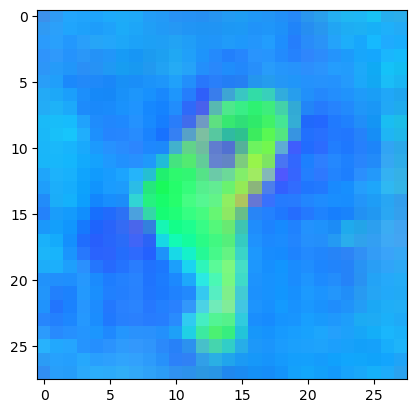

In [94]:
with torch.no_grad():
    reconstructed_image = vae(
        mnist_train[4, :, :, :].unsqueeze(0).to(device),
        mnist_train_target[4, :].unsqueeze(0).to(device),
    )[0]
    plt.imshow(reconstructed_image.cpu().squeeze().permute(1, 2, 0))

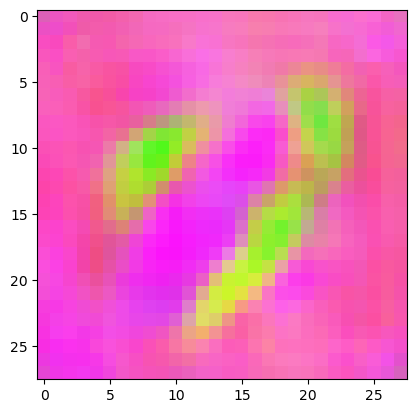

In [59]:
with torch.no_grad():
    condition = mnist_train_target[3, :]
    condition[0] = 5
    generated_image = vae.generate(condition.unsqueeze(0).to(device))
    plt.imshow(generated_image.cpu().squeeze().permute(1, 2, 0))